### library import

In [1]:
import numpy as np
import scipy.misc as scm
import math
import random

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

### Modelingクラス

In [2]:
class Modeling:

    def __init__(self,lambda_poisson, repeat):
        self.lambda_poisson = lambda_poisson
        self.collecting_deadline = lambda_poisson * 2
        self.repeat = repeat
        self.poisson = np.random.poisson(lambda_poisson, 1000)

    def half_num(self,num):
        return int(math.ceil(float(num) / 2))

    def simulate_when_people_come_list(self, people_num):
        when_people_come = [0] * self.collecting_deadline
        for t in range(people_num):
            when_people_come[t] = 1
        random.shuffle(when_people_come)
        return when_people_come
    
    def possibility_correct_by_majority_vote(self, people_num, possibility_correct):
        return (1 - self.relative_error_by_majority_vote(people_num, possibility_correct))

    def relative_error_by_majority_vote(self, people_num, possibility_correct):
        half_num = self.half_num(people_num)
        relative_error = 0
        for t in range(half_num):
            relative_error += (possibility_correct**t) * ((1 - possibility_correct)**(people_num - t)) * scm.comb(people_num, t)
        return relative_error
    
    def possibility_correct_array_by_half_opinion(self, finish_num, possibility_correct):
        possibility_correct_arr = []
        for t in range(finish_num):
            possibility_correct_arr.append((possibility_correct**finish_num) * ((1 - possibility_correct)**t) * scm.comb(finish_num - 1 + t, t))
        return possibility_correct_arr
        
    def relative_error_array_by_half_opinion(self, finish_num, possibility_correct):
        relative_error = []
        for t in range(finish_num):
            relative_error.append(((1 - possibility_correct)**finish_num) * (possibility_correct**t) * scm.comb(finish_num - 1 + t, t))
        return relative_error

    def deciding_by_first_person_with_poisson(self, possibility_correct, weight):
        temp_method_utility = 0
        for n in range(self.repeat):
            people_num = self.poisson[n] # ポアソン分布したがって来る人数
            when_people_come = self.simulate_when_people_come_list(people_num)
            method_utility = 0
            for i in range(len(when_people_come)):
                if when_people_come[i] == 0: continue
                method_utility += possibility_correct - weight * (float(i) / self.collecting_deadline)
                break
            temp_method_utility += method_utility
        average_method_utility = temp_method_utility / self.repeat
        return average_method_utility

    def deciding_by_majority_vote_with_poisson(self, possibility_correct, majority_vote_people, weight):
        temp_method_utility = 0
        for n in range(self.repeat):
            people_num = self.poisson[n]
            when_people_come = self.simulate_when_people_come_list(people_num)
            method_utility = 0
            people_count = 0
            if people_num < majority_vote_people: continue
            for i in range(len(when_people_come)):
                if when_people_come[i] == 0: continue
                people_count += 1
                if people_count == majority_vote_people:
                    method_utility +=  self.possibility_correct_by_majority_vote(people_count, possibility_correct) - weight * (float(i) / self.collecting_deadline)
                    break
            temp_method_utility += method_utility
        average_method_utility = temp_method_utility / self.repeat
        return average_method_utility

    def deciding_by_half_opinion_with_poisson(self, possibility_correct, temp_people_num, weight):
        temp_method_utility = 0
        for n in range(self.repeat):
            people_num = self.poisson[n]
            when_people_come = self.simulate_when_people_come_list(people_num)
            method_utility = 0
            people_count = 0
            people_count_arr = []
            if people_num < temp_people_num: continue
            for i in range(len(when_people_come)):
                if when_people_come[i] == 0: continue
                people_count_arr.append(i)
                people_count += 1
                if people_count == temp_people_num:
                    possibility_correct_arr = self.possibility_correct_array_by_half_opinion(self.half_num(temp_people_num), possibility_correct)
                    sum_possibility = sum(possibility_correct_arr)
                    average_index = 0
                    for index in range(len(possibility_correct_arr)):
                        average_index += people_count_arr[self.half_num(temp_people_num) - 1 + index] * (possibility_correct_arr[index] / sum_possibility)
                    method_utility = sum_possibility - weight * (float(average_index) / self.collecting_deadline)
                    break
            temp_method_utility += method_utility
        average_method_utility = temp_method_utility / self.repeat
        return average_method_utility

    def deciding_by_time_limit_with_poisson(self, possibility_correct, time_limit, weight):
        temp_method_utility = 0
        for n in range(self.repeat):
            people_num = self.poisson[n]
            when_people_come = self.simulate_when_people_come_list(people_num)
            method_utility = 0
            people_count = 0
            for i in range(len(when_people_come)):
                if i >= time_limit and people_count >= 1:
                    method_utility = (1 - self.relative_error_by_majority_vote(people_count, possibility_correct)) - weight * (float(i) / self.collecting_deadline)
                    break
                if when_people_come[i] == 0: continue
                people_count += 1
            temp_method_utility += method_utility
        average_method_utility = temp_method_utility / self.repeat
        return average_method_utility

    def deciding_by_first_person_with_poisson_for_variance(self, possibility_correct, weight):
        temp_method_utility = []
        for n in range(self.repeat):
            people_num = self.poisson[n] # ポアソン分布したがって来る人数
            when_people_come = self.simulate_when_people_come_list(people_num)
            method_utility = 0
            for i in range(len(when_people_come)):
                if when_people_come[i] == 0: continue
                method_utility += possibility_correct - weight * (float(i) / self.collecting_deadline)
                break
            temp_method_utility.append(method_utility)
        variance_method_utility = np.var(temp_method_utility)
        return variance_method_utility

    def deciding_by_majority_vote_with_poisson_for_variance(self, possibility_correct, majority_vote_people, weight):
        temp_method_utility = []
        for n in range(self.repeat):
            people_num = self.poisson[n]
            when_people_come = self.simulate_when_people_come_list(people_num)
            method_utility = 0
            people_count = 0
            if people_num < majority_vote_people: continue
            for i in range(len(when_people_come)):
                if when_people_come[i] == 0: continue
                people_count += 1
                if people_count == majority_vote_people:
                    method_utility += (1 - self.relative_error_by_majority_vote(people_count, possibility_correct)) - weight * (float(i) / self.collecting_deadline)
                    break
            temp_method_utility.append(method_utility)
        variance_method_utility = np.var(temp_method_utility)
        return variance_method_utility

    def deciding_by_half_opinion_with_poisson_for_variance(self, possibility_correct, temp_people_num, weight):
        temp_method_utility = []
        for n in range(self.repeat):
            people_num = self.poisson[n]
            when_people_come = self.simulate_when_people_come_list(people_num)
            method_utility = 0
            people_count = 0
            people_count_arr = []
            if people_num < temp_people_num: continue
            for i in range(len(when_people_come)):
                if when_people_come[i] == 0: continue
                people_count_arr.append(i)
                people_count += 1
                if people_count == temp_people_num:
                    possibility_correct_arr = self.possibility_correct_array_by_half_opinion(self.half_num(temp_people_num), possibility_correct)
                    sum_possibility = sum(possibility_correct_arr)
                    average_index = 0
                    for index in range(len(possibility_correct_arr)):
                        average_index += people_count_arr[self.half_num(temp_people_num) - 1 + index] * (possibility_correct_arr[index] / sum_possibility)
                    method_utility = sum_possibility - weight * (float(average_index) / self.collecting_deadline)
                    break
            temp_method_utility.append(method_utility)
        variance_method_utility = np.var(temp_method_utility)
        return variance_method_utility

    def deciding_by_time_limit_with_poisson_for_variance(self, possibility_correct, time_limit, weight):
        temp_method_utility = []
        for n in range(self.repeat):
            people_num = self.poisson[n]
            when_people_come = self.simulate_when_people_come_list(people_num)
            method_utility = 0
            people_count = 0
            for i in range(len(when_people_come)):
                if i >= time_limit and people_count >= 1:
                    method_utility = (1 - self.relative_error_by_majority_vote(people_count, possibility_correct)) - weight * (float(i) / self.collecting_deadline)
                    break
                if when_people_come[i] == 0: continue
                people_count += 1
            temp_method_utility.append(method_utility)
        variance_method_utility = np.var(temp_method_utility)
        return variance_method_utility

    # -----以上はRubyと同じ実装-----
    # -----ここからは新しい実装-----
    # 個人の正解率を一様分布で表現する
    # s_possibilityからs_possibility + t_possibilityまでの一様分布の個人の正解率
    def deciding_by_first_person_with_uniform_distribution(self, s_possibility, t_possibility, weight):
        temp_method_utility = 0
        for n in range(self.repeat):
            people_num = self.poisson[n] # ポアソン分布したがって来る人数
            possibility_correct = (np.random.rand() * t_possibility + s_possibility) / 100
            when_people_come = self.simulate_when_people_come_list(people_num)
            method_utility = 0
            for i in range(len(when_people_come)):
                if when_people_come[i] == 0: continue
                method_utility += possibility_correct - weight * (float(i) / self.collecting_deadline)
                break
            temp_method_utility += method_utility
        average_method_utility = temp_method_utility / self.repeat
        return average_method_utility

    def deciding_by_majority_vote_with_uniform_distribution(self, s_possibility, t_possibility, majority_vote_people, weight):
        temp_method_utility = 0
        for n in range(self.repeat):
            people_num = self.poisson[n]
            possibility_correct = (np.random.rand() * t_possibility + s_possibility) / 100
            when_people_come = self.simulate_when_people_come_list(people_num)
            method_utility = 0
            people_count = 0
            if people_num < majority_vote_people: continue
            for i in range(len(when_people_come)):
                if when_people_come[i] == 0: continue
                people_count += 1
                if people_count == majority_vote_people:
                    method_utility += (1 - self.relative_error_by_majority_vote(people_count, possibility_correct)) - weight * (float(i) / self.collecting_deadline)
                    break
            temp_method_utility += method_utility
        average_method_utility = temp_method_utility / self.repeat
        return average_method_utility

    def deciding_by_half_opinion_with_uniform_distribution(self, s_possibility, t_possibility, temp_people_num, weight):
        temp_method_utility = 0
        for n in range(self.repeat):
            people_num = self.poisson[n]
            possibility_correct = (np.random.rand() * t_possibility + s_possibility) / 100
            when_people_come = self.simulate_when_people_come_list(people_num)
            method_utility = 0
            people_count = 0
            people_count_arr = []
            if people_num < temp_people_num: continue
            for i in range(len(when_people_come)):
                if when_people_come[i] == 0: continue
                people_count_arr.append(i)
                people_count += 1
                if people_count == temp_people_num:
                    possibility_correct_arr = self.possibility_correct_array_by_half_opinion(self.half_num(temp_people_num), possibility_correct)
                    sum_possibility = sum(possibility_correct_arr)
                    average_index = 0
                    for index in range(len(possibility_correct_arr)):
                        average_index += people_count_arr[self.half_num(temp_people_num) - 1 + index] * (possibility_correct_arr[index] / sum_possibility)
                    method_utility = sum_possibility - weight * (float(average_index) / self.collecting_deadline)
                    break
            temp_method_utility += method_utility
        average_method_utility = temp_method_utility / self.repeat
        return average_method_utility

    def deciding_by_time_limit_with_uniform_distribution(self, s_possibility, t_possibility, time_limit, weight):
        temp_method_utility = 0
        for n in range(self.repeat):
            people_num = self.poisson[n]
            possibility_correct = (np.random.rand() * t_possibility + s_possibility) / 100
            when_people_come = self.simulate_when_people_come_list(people_num)
            method_utility = 0
            people_count = 0
            for i in range(len(when_people_come)):
                if i >= time_limit and people_count >= 1:
                    method_utility = (1 - self.relative_error_by_majority_vote(people_count, possibility_correct)) - weight * (float(i) / self.collecting_deadline)
                    break
                if when_people_come[i] == 0: continue
                people_count += 1
            temp_method_utility += method_utility
        average_method_utility = temp_method_utility / self.repeat
        return average_method_utility

    # 分散
    def deciding_by_first_person_with_uniform_distribution_for_variance(self, s_possibility, t_possibility, weight):
        temp_method_utility = []
        for n in range(self.repeat):
            people_num = self.poisson[n] # ポアソン分布したがって来る人数
            possibility_correct = (np.random.rand() * t_possibility + s_possibility) / 100
            when_people_come = self.simulate_when_people_come_list(people_num)
            method_utility = 0
            for i in range(len(when_people_come)):
                if when_people_come[i] == 0: continue
                method_utility += possibility_correct - weight * (float(i) / self.collecting_deadline)
                break
            temp_method_utility.append(method_utility)
        variance_method_utility = np.var(temp_method_utility)
        return variance_method_utility

    def deciding_by_majority_vote_with_uniform_distribution_for_variance(self, s_possibility, t_possibility, majority_vote_people, weight):
        temp_method_utility = []
        for n in range(self.repeat):
            people_num = self.poisson[n]
            possibility_correct = (np.random.rand() * t_possibility + s_possibility) / 100
            when_people_come = self.simulate_when_people_come_list(people_num)
            method_utility = 0
            people_count = 0
            if people_num < majority_vote_people: continue
            for i in range(len(when_people_come)):
                if when_people_come[i] == 0: continue
                people_count += 1
                if people_count == majority_vote_people:
                    method_utility += (1 - self.relative_error_by_majority_vote(people_count, possibility_correct)) - weight * (float(i) / self.collecting_deadline)
                    break
            temp_method_utility.append(method_utility)
        variance_method_utility = np.var(temp_method_utility)
        return variance_method_utility

    def deciding_by_half_opinion_with_uniform_distribution_for_variance(self, s_possibility, t_possibility, temp_people_num, weight):
        temp_method_utility = []
        for n in range(self.repeat):
            people_num = self.poisson[n]
            possibility_correct = (np.random.rand() * t_possibility + s_possibility) / 100
            when_people_come = self.simulate_when_people_come_list(people_num)
            method_utility = 0
            people_count = 0
            people_count_arr = []
            if people_num < temp_people_num: continue
            for i in range(len(when_people_come)):
                if when_people_come[i] == 0: continue
                people_count_arr.append(i)
                people_count += 1
                if people_count == temp_people_num:
                    possibility_correct_arr = self.possibility_correct_array_by_half_opinion(self.half_num(temp_people_num), possibility_correct)
                    sum_possibility = sum(possibility_correct_arr)
                    average_index = 0
                    for index in range(len(possibility_correct_arr)):
                        average_index += people_count_arr[self.half_num(temp_people_num) - 1 + index] * (possibility_correct_arr[index] / sum_possibility)
                    method_utility = sum_possibility - weight * (float(average_index) / self.collecting_deadline)
                    break
            temp_method_utility.append(method_utility)
        variance_method_utility = np.var(temp_method_utility)
        return variance_method_utility

    def deciding_by_time_limit_with_uniform_distribution_for_variance(self, s_possibility, t_possibility, time_limit, weight):
        temp_method_utility = []
        for n in range(self.repeat):
            people_num = self.poisson[n]
            possibility_correct = (np.random.rand() * t_possibility + s_possibility) / 100
            when_people_come = self.simulate_when_people_come_list(people_num)
            method_utility = 0
            people_count = 0
            for i in range(len(when_people_come)):
                if i >= time_limit and people_count >= 1:
                    method_utility = (1 - self.relative_error_by_majority_vote(people_count, possibility_correct)) - weight * (float(i) / self.collecting_deadline)
                    break
                if when_people_come[i] == 0: continue
                people_count += 1
            temp_method_utility.append(method_utility)
        variance_method_utility = np.var(temp_method_utility)
        return variance_method_utility


    # ベースライン手法
    # 今X人いる 誤差をε以下にしたい
    # 存在する方法のなかから最善のものを選択してそれがX人を下回るならそれを採用する
    # 存在する方法
    # *個人の意見
    # *多数決
    # *自信による重み付け
    # *自信の最大のもの
    # *SP
    # Xを超えてしまったなら、εを大きくしてこれを繰り返す
    def baseline_method(self, people_num, relative_error):
        method_dict = {}
        pass


### PlotGraphクラス

In [ ]:
class PlotGraph:

    def __init__(self, lambda_poisson, repeat, weight, people_num, possibility_correct, time_limit):
        self.lambda_poisson = lambda_poisson
        self.repeat = repeat
        self.weight = weight
        self.model = Modeling(lambda_poisson, repeat)
        self.people_num = people_num
        self.possibility_correct = possibility_correct
        self.time_limit = time_limit

    def plot_error_possibility_graph(self):
        x_axis = np.linspace(50,100,50)
        y_axis_majority_vote = self.model.relative_error_by_majority_vote(self.people_num, x_axis / 100)
        y_axis_half_opinion = sum(self.model.relative_error_array_by_half_opinion(self.model.half_num(self.people_num), x_axis / 100))
        plt.hold(True)
        plt.title('error_possibility_graph %s people' % self.people_num)
        plt.xlabel('Possibility of correct')
        plt.ylabel('Relative error')
        plt.plot(x_axis, y_axis_majority_vote, label='Majority vote')
        plt.plot(x_axis, y_axis_half_opinion, label='Half opinion')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()

    # 必要になったら実装
    def plot_cost_error_graph(self):
        pass

    def plot_error_possibility_graph_by_people_num(self):
        x_axis = np.linspace(50,100,50)
        y_axis_arr = []
        for t in range(30):
            y_axis_arr.append(self.model.relative_error_by_majority_vote(1 + 2 * t, x_axis / 100))
        plt.hold(True)
        plt.title('Error-possibility graph by people number')
        plt.xlabel('Possibility of correct')
        plt.ylabel('Relative error')
        for y_axis in y_axis_arr:
            plt.plot(x_axis, y_axis)
        plt.show()

    # 必要になったら実装
    def plot_cost_error_graph_by_possibility(self):
        pass

    def plot_utility_possibility_average_graph(self):
        x_axis = np.linspace(0.5,1.0,50)
        y_axis_dict = {}
        y_axis_dict["First peson"] = [self.model.deciding_by_first_person_with_poisson(x, self.weight) for x in x_axis]
        y_axis_dict["Majority vote"] = [self.model.deciding_by_majority_vote_with_poisson(x, self.people_num, self.weight) for x in x_axis]
        y_axis_dict["Half opinion"] = [self.model.deciding_by_half_opinion_with_poisson(x, self.people_num, self.weight) for x in x_axis]
        y_axis_dict["Time limit"] = [self.model.deciding_by_time_limit_with_poisson(x, self.time_limit, self.weight) for x in x_axis]
        plt.hold(True)
        plt.title('Utility-possibility graph')
        plt.xlabel('Possibility correct')
        plt.ylabel('Utility')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()

    def plot_utility_possibility_variance_graph(self):
        x_axis = np.linspace(0.5,1.0,50)
        y_axis_dict = {}
        y_axis_dict["First peson"] = [self.model.deciding_by_first_person_with_poisson_for_variance(x, self.weight) for x in x_axis]
        y_axis_dict["Majority vote"] = [self.model.deciding_by_majority_vote_with_poisson_for_variance(x, self.people_num, self.weight) for x in x_axis]
        y_axis_dict["Half opinion"] = [self.model.deciding_by_half_opinion_with_poisson_for_variance(x, self.people_num, self.weight) for x in x_axis]
        y_axis_dict["Time limit"] = [self.model.deciding_by_time_limit_with_poisson_for_variance(x, self.time_limit, self.weight) for x in x_axis]
        plt.hold(True)
        plt.title('Utility-possibility graph')
        plt.xlabel('Possibility correct')
        plt.ylabel('Variance')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()

    # -----以上はRubyと同じ実装-----
    # -----ここからは新しい実装-----
    # 縦軸をutility、横軸を重みにする
    # 重みを0.0,,,1.0と遷移させていく
    def plot_utility_weight_average_graph(self):
        x_axis = np.linspace(0.0, 1.0, 50)
        y_axis_dict = {}
        y_axis_dict["First peson"] = [self.model.deciding_by_first_person_with_poisson(self.possibility_correct, x) for x in x_axis]
        y_axis_dict["Majority vote"] = [self.model.deciding_by_majority_vote_with_poisson(self.possibility_correct, self.people_num, x) for x in x_axis]
        y_axis_dict["Half opinion"] = [self.model.deciding_by_half_opinion_with_poisson(self.possibility_correct, self.people_num, x) for x in x_axis]
        y_axis_dict["Time limit"] = [self.model.deciding_by_time_limit_with_poisson(self.possibility_correct, self.time_limit, x) for x in x_axis]
        plt.hold(True)
        plt.title('Utility-weight graph')
        plt.xlabel('weight')
        plt.ylabel('Utility')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()

    def plot_utility_weight_variance_graph(self):
        x_axis = np.linspace(0.0, 1.0, 50)
        y_axis_dict = {}
        y_axis_dict["First peson"] = [self.model.deciding_by_first_person_with_poisson_for_variance(self.possibility_correct, x) for x in x_axis]
        y_axis_dict["Majority vote"] = [self.model.deciding_by_majority_vote_with_poisson_for_variance(self.possibility_correct, self.people_num, x) for x in x_axis]
        y_axis_dict["Half opinion"] = [self.model.deciding_by_half_opinion_with_poisson_for_variance(self.possibility_correct, self.people_num, x) for x in x_axis]
        y_axis_dict["Time limit"] = [self.model.deciding_by_time_limit_with_poisson_for_variance(self.possibility_correct, self.time_limit, x) for x in x_axis]
        plt.hold(True)
        plt.title('Utility-weight graph')
        plt.xlabel('weight')
        plt.ylabel('Variance')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()

    # 多数決を行う人数や時間制限どれくらいが最適であるか
    # ポアソン分布の平均にも依存すると考えられる
    def plot_utility_possibility_average_graph_for_single_method(self):
        x_axis = np.linspace(0.5, 1.0, 50)
        # 最初の一人
        y_axis_dict = {}
        y_axis_dict["First person"] = [self.model.deciding_by_first_person_with_poisson(x, self.weight) for x in x_axis]
        plt.title('Utility-possibility graph')
        plt.xlabel('Possibility correct')
        plt.ylabel('Utility')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()
        # 多数決
        y_axis_dict = {}
        for t in range(15):
            y_axis_dict["Majority vote" + str(2 * t + 1)] = [self.model.deciding_by_majority_vote_with_poisson(x, 2 * t + 1, self.weight) for x in x_axis]
        plt.title('Utility-possibility graph')
        plt.xlabel('Possibility correct')
        plt.ylabel('Utility')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()
        # 半数
        y_axis_dict = {}
        for t in range(15):
            y_axis_dict["Half opinion" + str(2 * t + 1)] = [self.model.deciding_by_half_opinion_with_poisson(x, t + 1, self.weight) for x in x_axis]
        plt.title('Utility-possibility graph')
        plt.xlabel('Possibility correct')
        plt.ylabel('Utility')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()
        # 時間打ち切り
        y_axis_dict = {}
        for t in range(15):
            y_axis_dict["Time limit" + str(4 * t + 1)] = [self.model.deciding_by_time_limit_with_poisson(x, 4 * t + 1, self.weight) for x in x_axis]
        plt.title('Utility-possibility graph')
        plt.xlabel('Possibility correct')
        plt.ylabel('Utility')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()

    def plot_utility_possibility_variance_graph_for_single_method(self):
        x_axis = np.linspace(0.5, 1.0, 50)
        # 最初の一人
        y_axis_dict = {}
        y_axis_dict["First person"] = [self.model.deciding_by_first_person_with_poisson_for_variance(x, self.weight) for x in x_axis]
        plt.title('Utility-possibility graph')
        plt.xlabel('Possibility correct')
        plt.ylabel('Variance')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()
        # 多数決
        y_axis_dict = {}
        for t in range(15):
            y_axis_dict["Majority vote" + str(2 * t + 1)] = [self.model.deciding_by_majority_vote_with_poisson_for_variance(x, 2 * t + 1, self.weight) for x in x_axis]
        plt.title('Utility-possibility graph')
        plt.xlabel('Possibility correct')
        plt.ylabel('Variance')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()
        # 半数
        y_axis_dict = {}
        for t in range(15):
            y_axis_dict["Half opinion" + str(2 * t + 1)] = [self.model.deciding_by_half_opinion_with_poisson_for_variance(x, t + 1, self.weight) for x in x_axis]
        plt.title('Utility-possibility graph')
        plt.xlabel('Possibility correct')
        plt.ylabel('Variance')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()
        # 時間打ち切り
        y_axis_dict = {}
        for t in range(15):
            y_axis_dict["Time limit" + str(4 * t + 1)] = [self.model.deciding_by_time_limit_with_poisson_for_variance(x, 4 * t + 1, self.weight) for x in x_axis]
        plt.title('Utility-possibility graph')
        plt.xlabel('Possibility correct')
        plt.ylabel('Variance')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()

    def plot_utility_weight_average_graph_with_uniform_distribution(self):
        x_axis = np.linspace(0.0, 1.0, 50)
        y_axis_dict = {}
        y_axis_dict["First peson"] = [self.model.deciding_by_first_person_with_uniform_distribution(50, 50, x) for x in x_axis]
        y_axis_dict["Majority vote"] = [self.model.deciding_by_majority_vote_with_uniform_distribution(50, 50, self.people_num, x) for x in x_axis]
        y_axis_dict["Half opinion"] = [self.model.deciding_by_half_opinion_with_uniform_distribution(50, 50, self.people_num, x) for x in x_axis]
        y_axis_dict["Time limit"] = [self.model.deciding_by_time_limit_with_uniform_distribution(50, 50, self.time_limit, x) for x in x_axis]
        plt.hold(True)
        plt.title('Utility-weight graph')
        plt.xlabel('weight')
        plt.ylabel('Utility')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()

    def plot_utility_weight_variance_graph_with_uniform_distribution(self):
        x_axis = np.linspace(0.0, 1.0, 50)
        y_axis_dict = {}
        y_axis_dict["First peson"] = [self.model.deciding_by_first_person_with_uniform_distribution_for_variance(50, 50, x) for x in x_axis]
        y_axis_dict["Majority vote"] = [self.model.deciding_by_majority_vote_with_uniform_distribution_for_variance(50, 50, self.people_num, x) for x in x_axis]
        y_axis_dict["Half opinion"] = [self.model.deciding_by_half_opinion_with_uniform_distribution_for_variance(50, 50, self.people_num, x) for x in x_axis]
        y_axis_dict["Time limit"] = [self.model.deciding_by_time_limit_with_uniform_distribution_for_variance(50, 50, self.time_limit, x) for x in x_axis]
        plt.hold(True)
        plt.title('Utility-weight graph')
        plt.xlabel('weight')
        plt.ylabel('Variance')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()


### main

/Users/kotaro/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  app.launch_new_instance()
/Users/kotaro/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/Users/kotaro/anaconda2/lib/python2.7/site-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


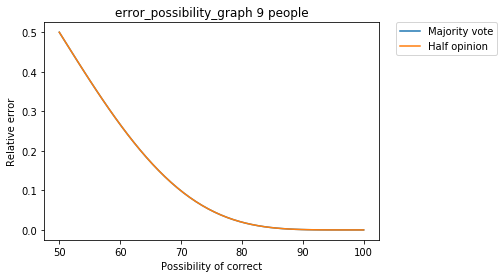

/Users/kotaro/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


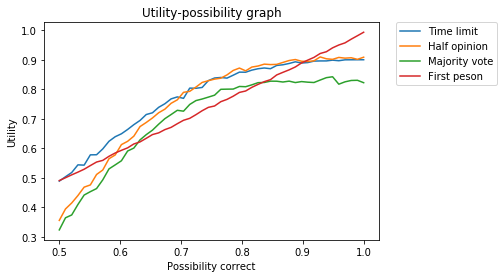

/Users/kotaro/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:69: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


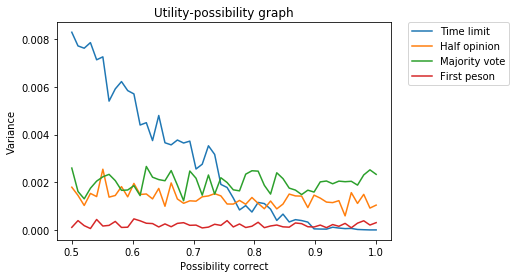

/Users/kotaro/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:89: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


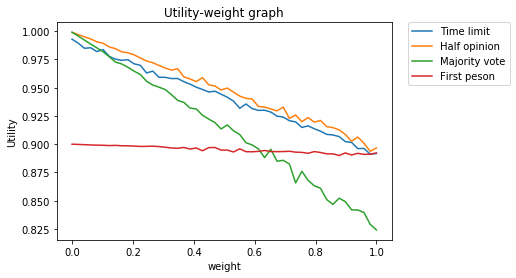

/Users/kotaro/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:105: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


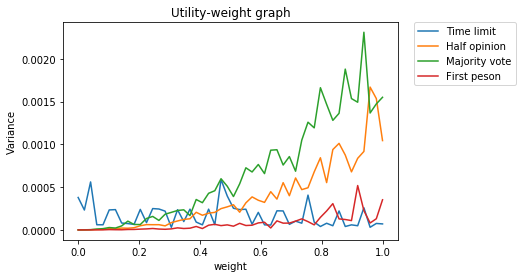

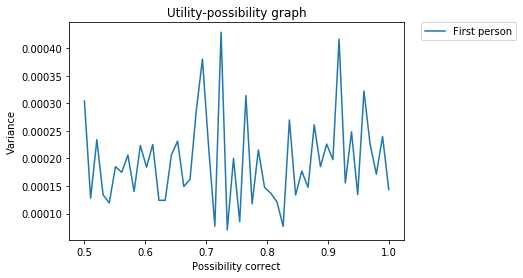

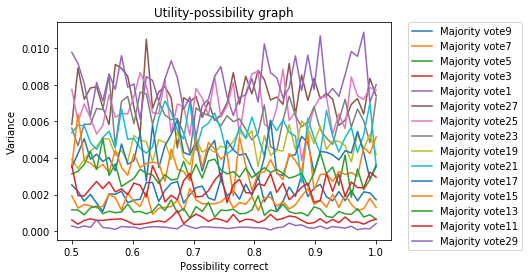

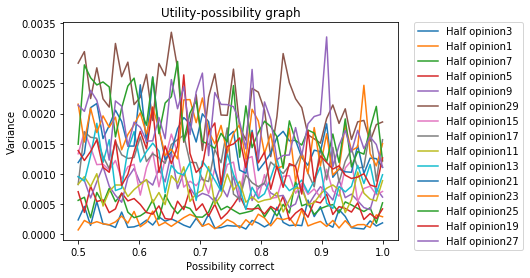

In [ ]:
pg = PlotGraph(50, 50, 1.0, 9, 0.9, 10)
pg.plot_error_possibility_graph()
pg.plot_utility_possibility_average_graph()
pg.plot_utility_possibility_variance_graph()
pg.plot_utility_weight_average_graph()
pg.plot_utility_weight_variance_graph()
pg.plot_utility_possibility_variance_graph_for_single_method()
pg.plot_utility_weight_average_graph_with_uniform_distribution()
pg.plot_utility_weight_variance_graph_with_uniform_distribution()

In [ ]:
x = 0.6

# 5人で多数決 
print (x**5) + (x**4) * (1-x) * 5 + (x**3)*((1-x)**2)*10
print "多数決に必要な人数 {}人".format(5)

# 先に３票か
all_sum = (x**3) + (x**2) * (1-x) * 3 * x + (x**2)*((1-x)**2)*6*x
print all_sum
print "こっちに必要な人数 {}人".format(3 / all_sum * (x**3) + 4 / all_sum*((x**2) * (1-x) * 3 * x) + 5 / all_sum *(x**2)*((1-x)**2)*6*x)
print (x**3)
print (x**2) * (1-x) * 3 * x 
print (x**2)*((1-x)**2)*6*x

print "---------- TEST ---------"
model = Modeling(50,50)
print model.possibility_correct_by_majority_vote(5, 0.6)
print model.possibility_correct_array_by_half_opinion(3, 0.6)

print model.deciding_by_majority_vote_with_poisson(0.5, 5, 0)
print model.deciding_by_half_opinion_with_poisson(0.5, 5, 0)

